In [288]:
from proxmin import nmf
from proxmin.utils import Traceback
from scipy.optimize import linear_sum_assignment
from scipy.stats import binned_statistic
import numpy as np
import matplotlib.pyplot as plt
import time
from proxmin import operators as po
from functools import partial

In [289]:
data = np.load("hsc_stacked.npy")

In [290]:
redshifts = data['z_cl']

# Bin the cluster data by redshift
clusters1 = data[(redshifts > 0.1) & (redshifts < 0.2)]
clusters2 = data[(redshifts > 0.2) & (redshifts < 0.35)]
clusters3 = data[(redshifts > 0.35) & (redshifts < 0.5)]
clusters4 = data[(redshifts > 0.5) & (redshifts < 0.75)]
clusters5 = data[(redshifts > 0.75) & (redshifts < 1.2)]

In [291]:
num_radial_bins = 15

In [292]:
# Compute the average colors (and their variances) for a given redshift bin

def avg_colors(clusters):
    
    clusters = clusters[np.where(clusters['R'] > 0.01)]
    radii = np.array(clusters['R'])
    #radii = radii[np.where(radii > 0.01)]
    radial_bins = np.logspace(np.log10(np.amin(radii)), np.log10(np.amax(radii)), num_radial_bins + 1)
    #print(radial_bins)
    widths = np.diff(radial_bins)

    # Arrays containing magnitude data in four different filters
    g = np.array(clusters['gmag_forced_cmodel'])
    r = np.array(clusters['rmag_forced_cmodel'])
    i = np.array(clusters['imag_forced_cmodel'])
    z = np.array(clusters['zmag_forced_cmodel'])

    # For each color g-r, r-i, and i-z: first, throw out data points that have magnitudes of "nan" or "inf" (pruning the
    # arrays of radii and magnitudes accordingly), then use scipy.binned_statistic to sort the data into radial bins and
    # compute the mean and variance (noise^2) of the color values in those bins

    radii_gr_pruned = radii[np.isfinite(g) & np.isfinite(r)]
    gr = g[np.isfinite(g) & np.isfinite(r)] - r[np.isfinite(g) & np.isfinite(r)]
    count_gr = binned_statistic(radii_gr_pruned, gr, 'count', radial_bins)[0]
    mean_gr = binned_statistic(radii_gr_pruned, gr, 'mean', radial_bins)[0]
    var_gr = binned_statistic(radii_gr_pruned, gr, np.var, radial_bins)[0]
    var_gr /= count_gr

    radii_ri_pruned = radii[np.isfinite(r) & np.isfinite(i)]
    ri = r[np.isfinite(r) & np.isfinite(i)] - i[np.isfinite(r) & np.isfinite(i)]
    count_ri = binned_statistic(radii_ri_pruned, ri, 'count', radial_bins)[0]
    mean_ri = binned_statistic(radii_ri_pruned, ri, 'mean', radial_bins)[0]
    var_ri = binned_statistic(radii_ri_pruned, ri, np.var, radial_bins)[0]
    var_ri /= count_ri

    radii_iz_pruned = radii[np.isfinite(i) & np.isfinite(z)]
    iz = i[np.isfinite(i) & np.isfinite(z)] - z[np.isfinite(i) & np.isfinite(z)]
    count_iz = binned_statistic(radii_iz_pruned, iz, 'count', radial_bins)[0]
    mean_iz = binned_statistic(radii_iz_pruned, iz, 'mean', radial_bins)[0]
    var_iz = binned_statistic(radii_iz_pruned, iz, np.var, radial_bins)[0]
    var_iz /= count_iz

    # Compute the mean and variance of the i magnitudes over the same radial bins as above
    radii_i_pruned = radii[np.isfinite(i)]
    count_i = binned_statistic(radii_i_pruned, i, 'count', radial_bins)[0]
    mean_i = binned_statistic(radii_i_pruned, i, 'mean', radial_bins)[0]
    var_i = binned_statistic(radii_i_pruned, i, np.var, radial_bins)[0]
    var_i /= count_i
    
    return (radial_bins, widths, (mean_gr, var_gr), (mean_ri, var_ri), (mean_iz, var_iz), (mean_i, var_i))

In [293]:
# Plot bar graphs for the average color data in a given redshift bin

def plot_profiles(clusters, z_bin_num):
    
    clusters_data = avg_colors(clusters)

    radial_bins = clusters_data[0]
    widths = clusters_data[1]
    
    # gr, ri, iz, and i are 2-tuples of the form (mean_color, var_color)
    gr = clusters_data[2]
    ri = clusters_data[3]
    iz = clusters_data[4]
    i = clusters_data[5]
    
    z_bins = ("1 (0.1 < z < 0.2)", "2 (0.2 < z < 0.35)", "3 (0.35 < z < 0.5)", "4 (0.5 < z < 0.75)", 
             "5 (0.75 < z < 1.2)")

    plt.bar(radial_bins[:-1], gr[0], width=widths, fill=False, align="edge", yerr=np.sqrt(gr[1]))
    plt.xscale('log')
    plt.title("Average g-r Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average g-r [magnitudes]")
    plt.show()

    plt.bar(radial_bins[:-1], ri[0], width=widths, fill=False, align="edge", yerr=np.sqrt(ri[1]))
    plt.xscale('log')
    plt.title("Average r-i Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average r-i [magnitudes]")
    plt.show()

    plt.bar(radial_bins[:-1], iz[0], width=widths, fill=False, align="edge", yerr=np.sqrt(iz[1]))
    plt.xscale('log')
    plt.title("Average i-z Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average i-z [magnitudes]")
    plt.show()

    plt.bar(radial_bins[:-1], i[0], width=widths, fill=False, align="edge", yerr=np.sqrt(i[1]))
    plt.xscale('log')
    plt.title("Average i-filter Magnitude vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average i [magnitudes]")
    plt.show()
    
    return clusters_data

In [294]:
# Use NMF to unmix the color profiles generated by plot_profiles and avg_colors
# The arguments of "unmix" are 2-tuples of the form (mean_color, var_color). For example, gr is really (mean_gr, var_gr)

def unmix(gr, ri, iz, i):
    n = num_radial_bins     # component resolution
    k = 2                   # number of components
    b = 4                   # number of observations (b=4 for g-r, r-i, i-z, and i)

    # Data matrix to be unmixed
    Y = np.array([gr[0], ri[0], iz[0], i[0]])
    
    # if noise is variable, specify variance matrix of the same shape as Y
    W = 1. / np.array([gr[1], ri[1], iz[1], i[1]])

    # initialize and run NMF
    A = np.random.uniform(size = (b, k))
    S = np.random.uniform(size = (k, n))
    pA = po.prox_id
    pS = partial(po.prox_unity_plus, axis=0)
    
    nmf(Y, A, S, W=W, prox_A=pA, prox_S=pS, e_rel=1e-6, e_abs=0)
    
    return A, S

In [295]:
def plot_factorized_profiles(clusters_data, z_bin_num):
    

    radial_bins = clusters_data[0]
    bin_midpoints = (radial_bins[1:] * radial_bins[:-1]) ** 0.5
    widths = clusters_data[1]
    
    # gr, ri, iz, and i are 2-tuples of the form (mean_color, var_color)
    A, S = unmix(gr = clusters_data[2], ri = clusters_data[3], iz = clusters_data[4], i = clusters_data[5])
    print("A:\n", A, "\n")
    print("S:\n", S, "\n")
    
    z_bins = ("1 (0.1 < z < 0.2)", "2 (0.2 < z < 0.35)", "3 (0.35 < z < 0.5)", "4 (0.5 < z < 0.75)", 
             "5 (0.75 < z < 1.2)")
    
    # Plot S_k (the relative abundance of the kth component) vs. radius for each k
    
    for k in range(S.shape[0]):
        plt.plot(bin_midpoints, S[k], label = "Component %s" % (k+1))
    plt.xscale('log')
    plt.title("Relative Component Abundance vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel("Relative abundance")
    plt.legend()
    plt.show()
    
    
    Y_remixed = np.dot(A, S)
    
    # Plot the reconstructed color profiles following NMF 
    # (that is, plot Y_remixed = A x S, where A and S are the results of factorizing the initial data matrix Y)
    
    '''
    plt.bar(radial_bins[:-1], Y_remixed[0], width=widths, fill=False, align="edge")#, yerr=np.sqrt(gr[1]))
    plt.xscale('log')
    plt.title("Re-Mixed Average g-r Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average g-r [magnitudes]")
    plt.show()

    plt.bar(radial_bins[:-1], Y_remixed[1], width=widths, fill=False, align="edge")#, yerr=np.sqrt(ri[1]))
    plt.xscale('log')
    plt.title("Re-Mixed Average r-i Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average r-i [magnitudes]")
    plt.show()

    plt.bar(radial_bins[:-1], Y_remixed[2], width=widths, fill=False, align="edge")#, yerr=np.sqrt(iz[1]))
    plt.xscale('log')
    plt.title("Re-Mixed Average i-z Color vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average i-z [magnitudes]")
    plt.show()

    plt.bar(radial_bins[:-1], Y_remixed[3], width=widths, fill=False, align="edge")#, yerr=np.sqrt(i[1]))
    plt.xscale('log')
    plt.title("Re-Mixed Average i-filter Magnitude vs. Radius for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average i [magnitudes]")
    plt.show()
    
    
    # Plot the components (that is, the rows of S) for a given redshift bin
    
    plt.bar(radial_bins[:-1], S[0], width=widths, fill=False, align="edge")#, yerr=np.sqrt(i[1]))
    plt.xscale('log')
    plt.title("Component 1 for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average color [magnitudes]")
    plt.show()
    
    plt.bar(radial_bins[:-1], S[1], width=widths, fill=False, align="edge")#, yerr=np.sqrt(i[1]))
    plt.xscale('log')
    plt.title("Component 2 for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average color [magnitudes]") 
    plt.show()
    
    plt.bar(radial_bins[:-1], S[2], width=widths, fill=False, align="edge")#, yerr=np.sqrt(i[1]))
    plt.xscale('log')
    plt.title("Component 3 for Redshift Bin %s" % z_bins[z_bin_num - 1])
    plt.xlabel("Radius from cluster center [Mpc]")
    plt.ylabel ("Average color [magnitudes]")
    plt.show()
    '''
    

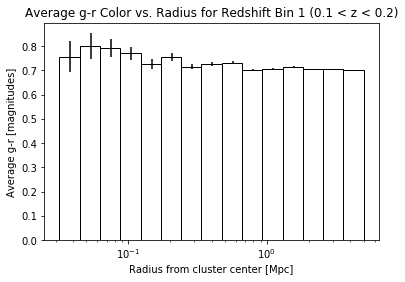

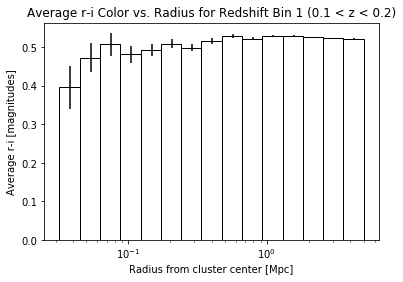

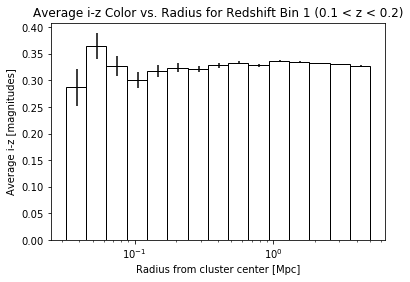

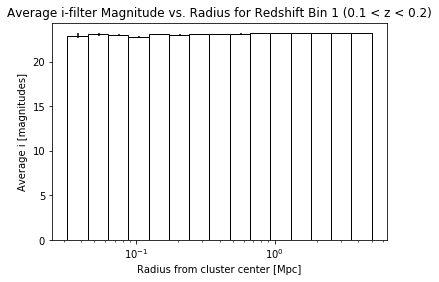

In [296]:
#Plot bar graphs for the clusters1 data

clusters1_data = plot_profiles(clusters1, 1)

A:
 [[  0.76411308   0.7013475 ]
 [  0.52835938   0.47650395]
 [  0.34660781   0.30388007]
 [ 23.07664631  23.07681999]] 

S:
 [[ 0.19697913  0.73564388  0.99400075  0.52292883  0.53463951  0.1919771
   0.55030498  0.60165941  0.49520884  0.49699449  0.4998171   0.50047785
   0.50029255  0.49957984  0.49987737]
 [ 0.80302087  0.26435612  0.00599925  0.47707117  0.46536049  0.8080229
   0.44969502  0.39834059  0.50479116  0.50300551  0.5001829   0.49952215
   0.49970745  0.50042016  0.50012263]] 



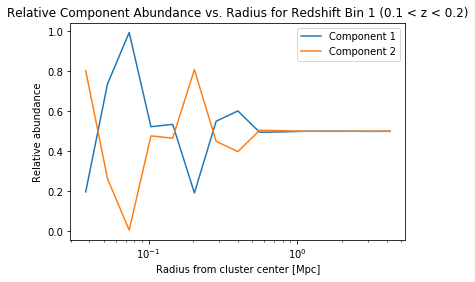

In [297]:
#Plot bar graphs for the post-NMF clusters1 profiles

plot_factorized_profiles(clusters1_data, 1)

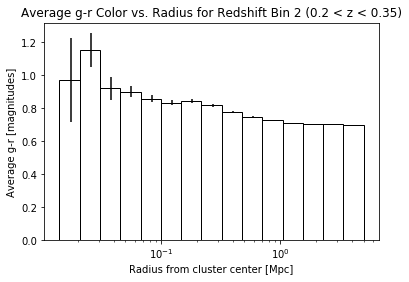

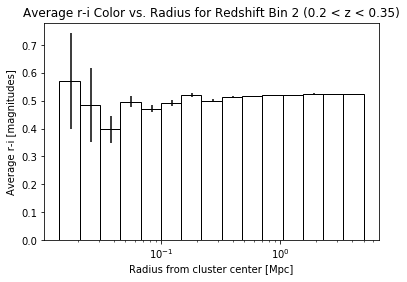

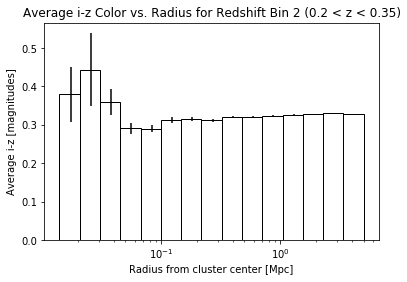

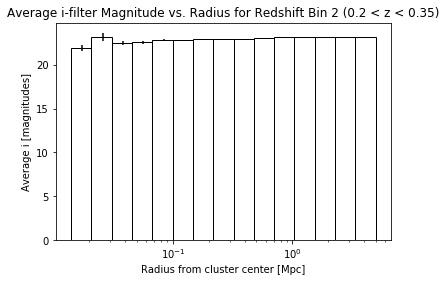

In [298]:
#Plot bar graphs for the clusters2 data

clusters2_data = plot_profiles(clusters2, 2)

A:
 [[  0.87250268   0.77227279]
 [  0.51350369   0.49466409]
 [  0.36108192   0.2993975 ]
 [ 23.07401768  22.69641818]] 

S:
 [[ 0.54877289  0.8206311   0.33864467  0.          0.52602832  1.
   0.65433028  0.54678219  0.50325964  0.50511198  0.50388187  0.5037001
   0.50397108  0.50373552  0.5037546 ]
 [ 0.45122711  0.1793689   0.66135533  1.          0.47397168  0.
   0.34566972  0.45321781  0.49674036  0.49488802  0.49611813  0.4962999
   0.49602892  0.49626448  0.4962454 ]] 



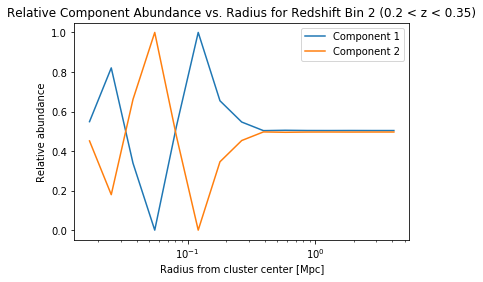

In [299]:
#Plot bar graphs for the post-NMF clusters2 profiles

plot_factorized_profiles(clusters2_data, 2)

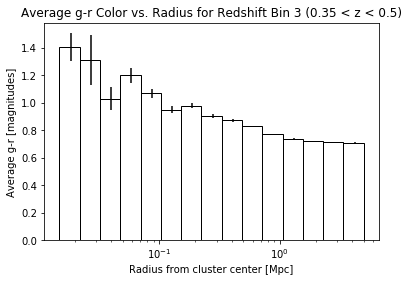

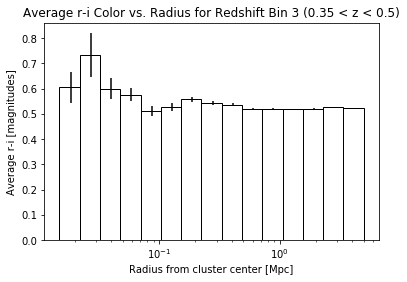

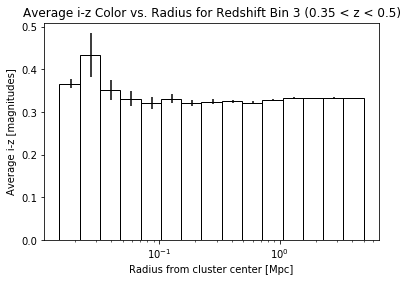

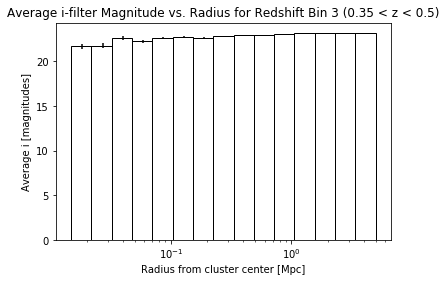

In [300]:
#Plot bar graphs for the clusters3 data

clusters3_data = plot_profiles(clusters3, 3)

A:
 [[  1.14166365   0.70359769]
 [  0.6189242    0.4738676 ]
 [  0.37640527   0.29283409]
 [ 22.25829143  23.32986466]] 

S:
 [[ 1.          1.          0.71479312  0.          0.60302351  0.50536454
   0.61939191  0.48050016  0.48811437  0.48847984  0.48357144  0.48385046
   0.4859273   0.48392254  0.48537477]
 [ 0.          0.          0.28520688  1.          0.39697649  0.49463546
   0.38060809  0.51949984  0.51188563  0.51152016  0.51642856  0.51614954
   0.5140727   0.51607746  0.51462523]] 



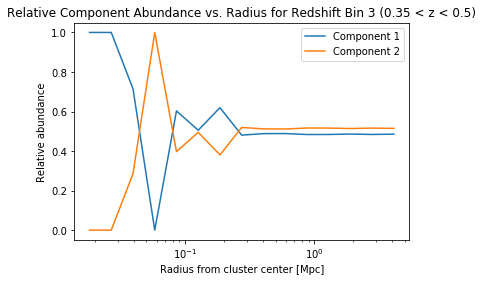

In [301]:
#Plot bar graphs for the post-NMF clusters3 profiles

plot_factorized_profiles(clusters3_data, 3)

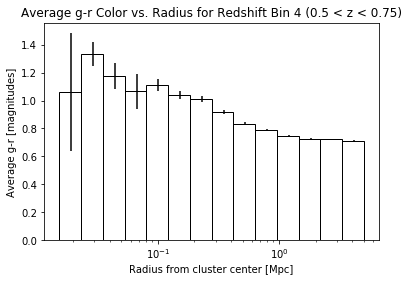

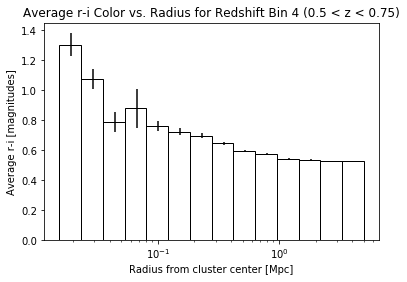

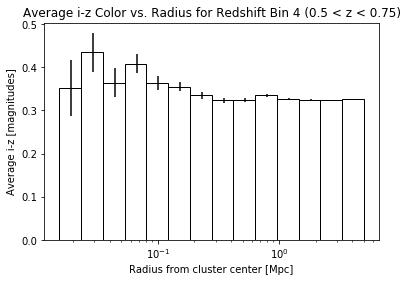

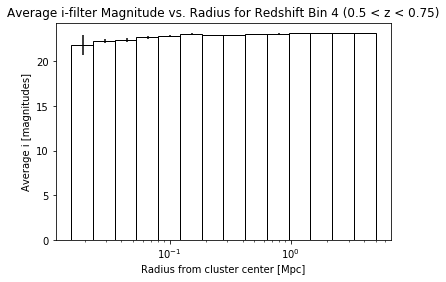

In [302]:
#Plot bar graphs for the clusters4 data

clusters4_data = plot_profiles(clusters4, 4)

In [303]:
#Plot bar graphs for the post-NMF clusters4 profiles

plot_factorized_profiles(clusters4_data, 4)

ArpackNoConvergence: ARPACK error -1: No convergence (81 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]

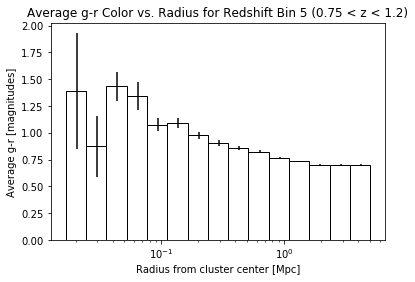

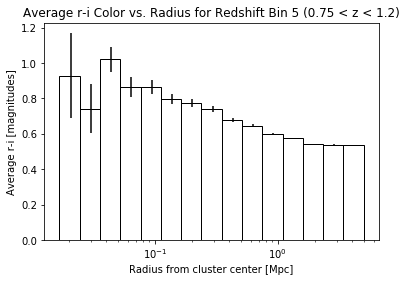

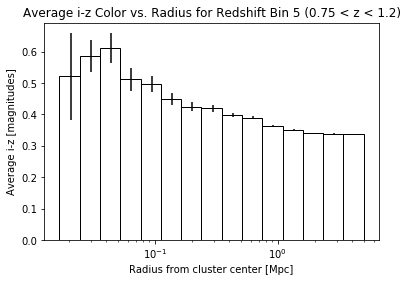

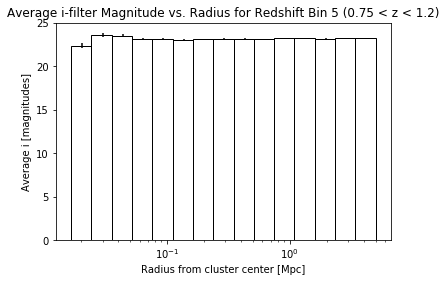

In [304]:
#Plot bar graphs for the clusters5 data

clusters5_data = plot_profiles(clusters5, 5)

A:
 [[  1.41031786   0.68579829]
 [  1.00717335   0.5516749 ]
 [  0.59056126   0.34218414]
 [ 23.02450705  23.23150996]] 

S:
 [[ 0.63935646  0.55357362  0.51024882  0.69038574  0.42322153  0.76551397
   0.50332846  0.44617007  0.43825475  0.23723148  0.4364166   0.          0.
   0.          0.        ]
 [ 0.36064354  0.44642638  0.48975118  0.30961426  0.57677847  0.23448603
   0.49667154  0.55382993  0.56174525  0.76276852  0.5635834   1.          1.
   1.          1.        ]] 



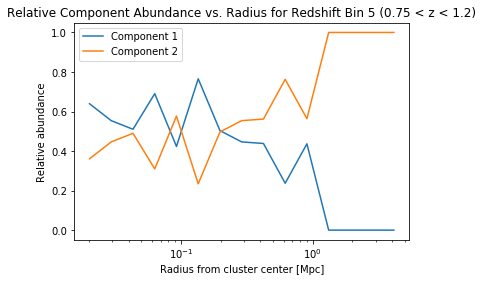

In [305]:
#Plot bar graphs for the post-NMF clusters5 profiles

plot_factorized_profiles(clusters5_data, 5)